Analyzing: Kaoru YAMAWAKI...


/tmp/ipykernel_24010/3197790609.py:130: UserWarning: Glyph 32207 (\N{CJK UNIFIED IDEOGRAPH-7DCF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24010/3197790609.py:130: UserWarning: Glyph 36208 (\N{CJK UNIFIED IDEOGRAPH-8D70}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24010/3197790609.py:130: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24010/3197790609.py:130: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24010/3197790609.py:130: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24010/3197790609.py:130: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_24010/3197790609.py:130: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from current font.

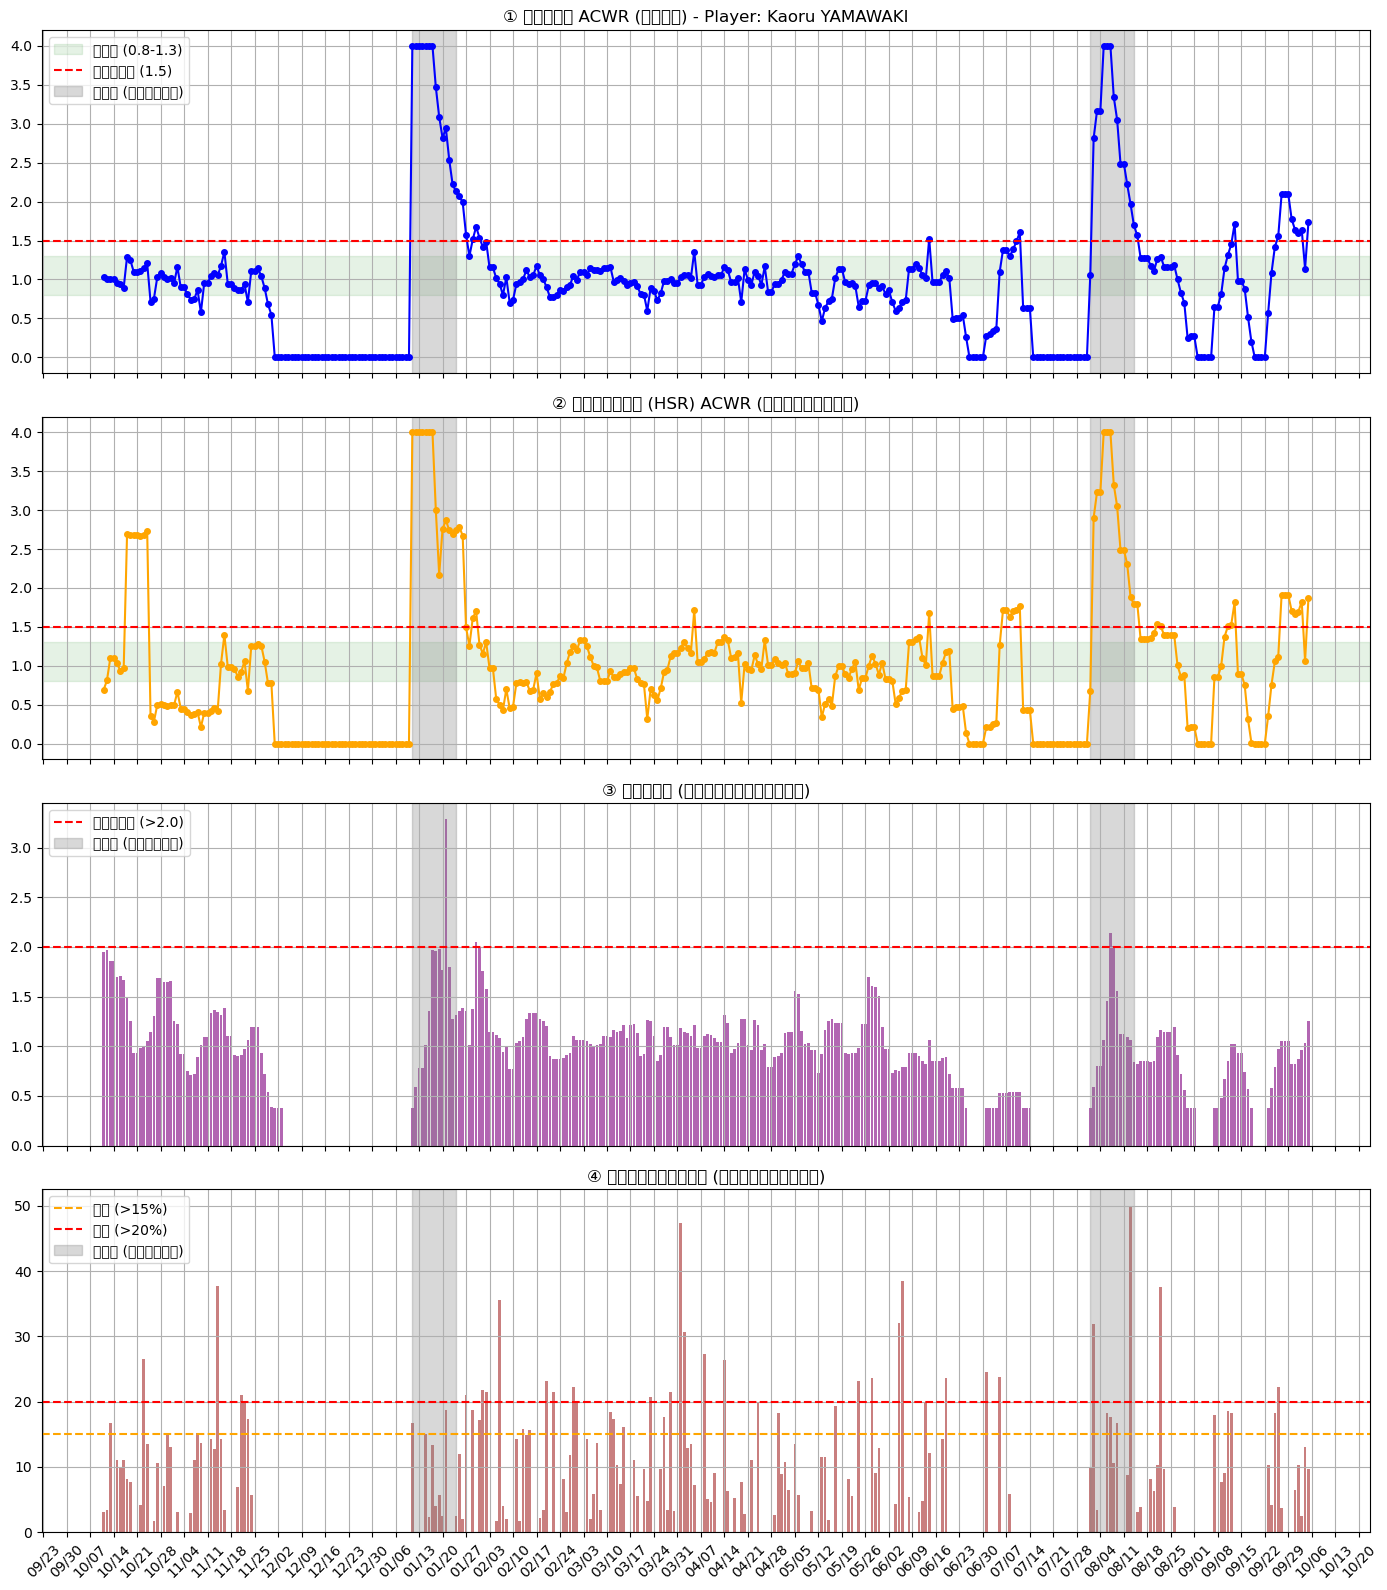

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# ==========================================
# 1. データ読み込みと基本設定
# ==========================================
# ファイルパスは環境に合わせて変更してください
df = pd.read_csv('/workspace/data/raw/StatsAllGroup.csv', encoding='cp932')
df['date_'] = pd.to_datetime(df['date_'], dayfirst=True)

# 指標の定義
# HSR (High Speed Running) = Band 5 (High) + Band 6 (Sprint)
df['HSR_Distance'] = df['velocity_band5_total_distance'] + df['velocity_band6_total_distance']
# IMA Total (左右合計)
df['IMA_Total'] = df['ima_band2_left_count'] + df['ima_band2_right_count']

# ==========================================
# 2. 測定期間（オフ明けグレーゾーン）の定義【★追加部分】
# ==========================================
# ここに定義した期間は、グラフ上でグレーアウトされ「測定中」扱いとなります
# チームスケジュールに合わせて適宜修正してください
MEASUREMENT_PERIODS = [
    (pd.Timestamp('2024-01-12'), pd.Timestamp('2024-01-25')), # 2024年始動
    (pd.Timestamp('2025-01-11'), pd.Timestamp('2025-01-24')), # 2025年始動
    (pd.Timestamp('2025-08-01'), pd.Timestamp('2025-08-14')), # 夏休み明け
]

# ==========================================
# 3. 分析関数の作成 (空白埋め処理入り)
# ==========================================
def analyze_player(player_name, df):
    print(f"Analyzing: {player_name}...")
    
    # その選手のデータだけ抽出
    player_df = df[df['athlete_name'] == player_name].copy()
    
    # 1日ごとの合計を算出 (午前・午後練を合算)
    cols = ['total_distance', 'HSR_Distance', 'total_player_load', 
            'ima_band2_left_count', 'ima_band2_right_count', 'IMA_Total']
    daily = player_df.groupby('date_')[cols].sum()
    
    # 【重要】カレンダーの空白を「0」で埋める
    full_idx = pd.date_range(start=daily.index.min(), end=daily.index.max(), freq='D')
    daily = daily.reindex(full_idx, fill_value=0)
    
    # --- 指標計算 ---
    
    # 1. ACWR (Total Distance & HSR)
    for metric in ['total_distance', 'HSR_Distance']:
        daily[f'{metric}_Acute'] = daily[metric].rolling(window=7, min_periods=1).mean()
        daily[f'{metric}_Chronic'] = daily[metric].rolling(window=28, min_periods=1).mean()
        # 0除算を防ぐ
        daily[f'{metric}_ACWR'] = np.where(daily[f'{metric}_Chronic'] > 0, 
                                           daily[f'{metric}_Acute'] / daily[f'{metric}_Chronic'], 0)
        
    # 2. Monotony (単調性指数)
    roll_mean = daily['total_player_load'].rolling(window=7).mean()
    roll_std = daily['total_player_load'].rolling(window=7).std()
    daily['Monotony'] = np.where(roll_std > 0, roll_mean / roll_std, 0)
    
    # 3. Asymmetry (左右非対称性)
    daily['Asymmetry_Index'] = np.where(daily['IMA_Total'] > 10,
                                        ((daily['ima_band2_left_count'] - daily['ima_band2_right_count']) / daily['IMA_Total']).abs() * 100,
                                        np.nan)
    
    return daily

# ==========================================
# 4. 実行と可視化
# ==========================================
top_player = df['athlete_name'].value_counts().index[0]
res_df = analyze_player(top_player, df)

# グラフ描画 (直近120日分に変更して、夏休み明けを表示するようにしました)
plot_data = res_df.tail(360) 
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# 【★追加関数】測定期間をハイライトする処理
def highlight_measurement_periods(ax):
    added_label = False
    for start, end in MEASUREMENT_PERIODS:
        # 表示範囲にかかっている場合のみ描画
        if (end >= plot_data.index.min()) and (start <= plot_data.index.max()):
            ax.axvspan(start, end, color='gray', alpha=0.3, 
                       label='測定中 (アラート無効)' if not added_label else "")
            added_label = True

# (1) Total Distance ACWR
axes[0].plot(plot_data.index, plot_data['total_distance_ACWR'], color='blue', marker='o', markersize=4)
axes[0].axhspan(0.8, 1.3, color='green', alpha=0.1, label='安全圏 (0.8-1.3)')
axes[0].axhline(1.5, color='red', linestyle='--', label='警告ライン (1.5)')
highlight_measurement_periods(axes[0]) # ★ここでハイライト適用
axes[0].set_title(f'① 総走行距離 ACWR (全体疲労) - Player: {top_player}')
axes[0].legend(loc='upper left')
axes[0].grid(True)

# (2) HSR ACWR
axes[1].plot(plot_data.index, plot_data['HSR_Distance_ACWR'], color='orange', marker='o', markersize=4)
axes[1].axhspan(0.8, 1.3, color='green', alpha=0.1)
axes[1].axhline(1.5, color='red', linestyle='--', label='警告ライン')
highlight_measurement_periods(axes[1])
axes[1].set_title('② スプリント距離 (HSR) ACWR (ハムストリング負荷)')
axes[1].grid(True)

# (3) Monotony
axes[2].bar(plot_data.index, plot_data['Monotony'], color='purple', alpha=0.6)
axes[2].axhline(2.0, color='red', linestyle='--', label='危険ライン (>2.0)')
highlight_measurement_periods(axes[2])
axes[2].set_title('③ モノトニー (オーバートレーニング兆候)')
axes[2].legend(loc='upper left')
axes[2].grid(True)

# (4) Asymmetry
axes[3].bar(plot_data.index, plot_data['Asymmetry_Index'], color='brown', alpha=0.6)
axes[3].axhline(15, color='orange', linestyle='--', label='注意 (>15%)')
axes[3].axhline(20, color='red', linestyle='--', label='異常 (>20%)')
highlight_measurement_periods(axes[3])
axes[3].set_title('④ 左右バランス非対称性 (怪我の予兆・代償動作)')
axes[3].legend(loc='upper left')
axes[3].grid(True)

# 日付フォーマット調整
axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
axes[3].xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()